# Step 1: Importing Libraries and Helper Functions

In [34]:
!pip3 install git+https://github.com/am1tyadav/tfutils.git

  Cloning https://github.com/am1tyadav/tfutils.git to c:\users\maksy\appdata\local\temp\pip-req-build-iuvq968m
  Resolved https://github.com/am1tyadav/tfutils.git to commit d55cdc73f2c79a5cbf63e4be14786978ab6f6c25
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none -q https://github.com/am1tyadav/tfutils.git 'C:\Users\maksy\AppData\Local\Temp\pip-req-build-iuvq968m'


In [1]:
import os
os.add_dll_directory("C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.5/bin")
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

<AddedDllDirectory('C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.5/bin')>

In [3]:
%matplotlib notebook
%matplotlib inline

import tensorflow as tf
import numpy as np
import tfutils
import time

from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Reshape, LeakyReLU, Dropout
from tensorflow.keras.models import Sequential
from IPython import display

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.7.0


# Step 2: Importing and Plotting the Data

In [4]:
(x_train, y_train), (x_test, y_test) = tfutils.datasets.mnist.load_data(one_hot=False)

x = np.concatenate([x_train, x_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

In [5]:
x = x.reshape(x.shape[0], 28, 28, 1).astype('float32')
x = (x - 127.5) / 127.5 

In [6]:
x.shape, y.shape

((70000, 28, 28, 1), (70000,))

In [7]:

BUFFER_SIZE = x.shape[0]
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

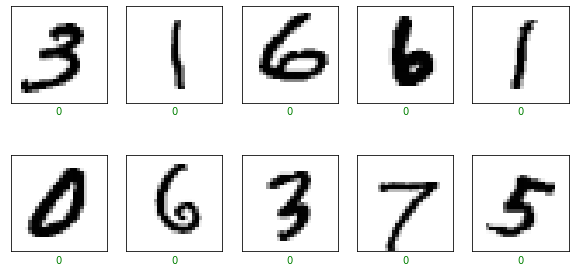

In [8]:
tfutils.datasets.mnist.plot_ten_random_examples(plt, x, y.reshape((BUFFER_SIZE, 1))).show()

# Step 3: Discriminator

In [9]:
discriminator = Sequential([
    Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
    LeakyReLU(),
    Dropout(0.3),

    Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    LeakyReLU(),
    Dropout(0.3),

    Flatten(),
    Dense(1),
])

discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0

# Step 4: Generator

In [10]:
generator = Sequential([
    Dense(7*7*256, use_bias=False, input_shape=(100,)),
    BatchNormalization(),
    LeakyReLU(),
    Reshape((7, 7, 256)),
    
    Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),

    Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),

    Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'),
])

generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)       

In [11]:
noise = tf.random.normal([1, 100])
gen_image = generator(noise, training=False)

plt.figure()
plt.imshow(np.reshape(gen_image, (28, 28)), cmap='binary')
plt.show()

In [ ]:
discriminator(gen_image)

Error: Session cannot generate requests

In [ ]:
epochs = 1
noise_dim = 100
seed = tf.random.normal([5*5, noise_dim])

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
stat = {}
buf = []
@tf.function
def train_step(image_batch):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_images = generator(noise, training=True)
        
        real_output = discriminator(image_batch, training=True)
        fake_output = discriminator(gen_images, training=True)
        
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        disc_loss = real_loss + fake_loss
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        print(real_loss[0])
        buf.append(real_loss)

        #stat[epoch].append([np.average(real_output), np.average(fake_output), real_loss.numpy(), fake_loss.numpy(), gen_loss.numpy()])

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

for epoch in range(epochs):
    stat[epoch] = []
    print(f'\tStart epoch {epoch}')
    start = time.time()
    for image_batch in train_dataset:
        train_step(image_batch)
    print(f'time: {time.time() - start}')
    #display.clear_output(wait=True)
    predictions = generator(seed, training=False)
    fig = plt.figure(figsize=(15,15))
    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
        plt.axis('off')
    plt.savefig(f'/content/drive/MyDrive/gan/epoch_{epoch}.png')
    plt.show()


Error: Session cannot generate requests

# Step 6: Training the GAN

In [87]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12247313515459808131
xla_global_id: -1
]


	Start epoch 0
time: 487.64351630210876
	Start epoch 1
time: 488.5309884548187
	Start epoch 2
time: 488.86191725730896
	Start epoch 3
time: 485.3599989414215
	Start epoch 4
time: 495.2239990234375
	Start epoch 5
time: 487.03599977493286
	Start epoch 6


KeyboardInterrupt: 

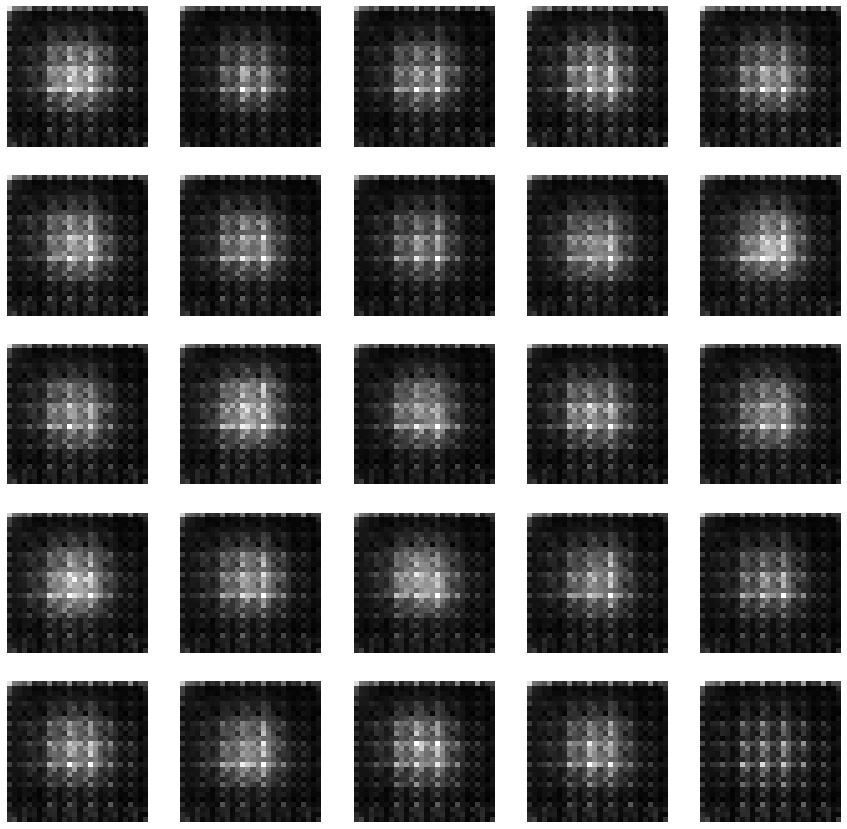

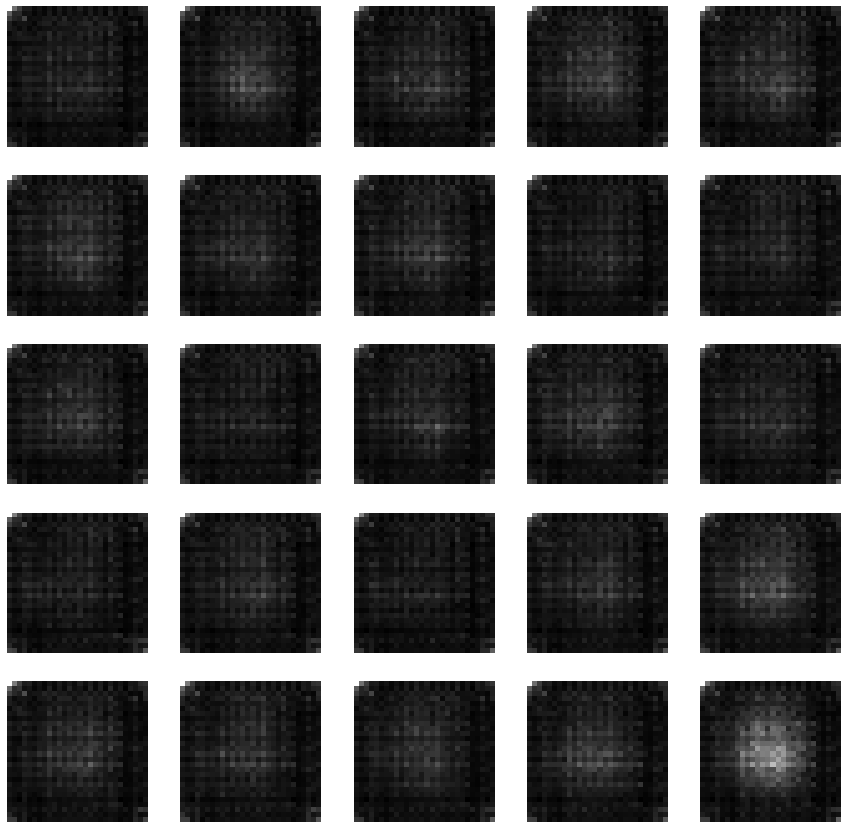

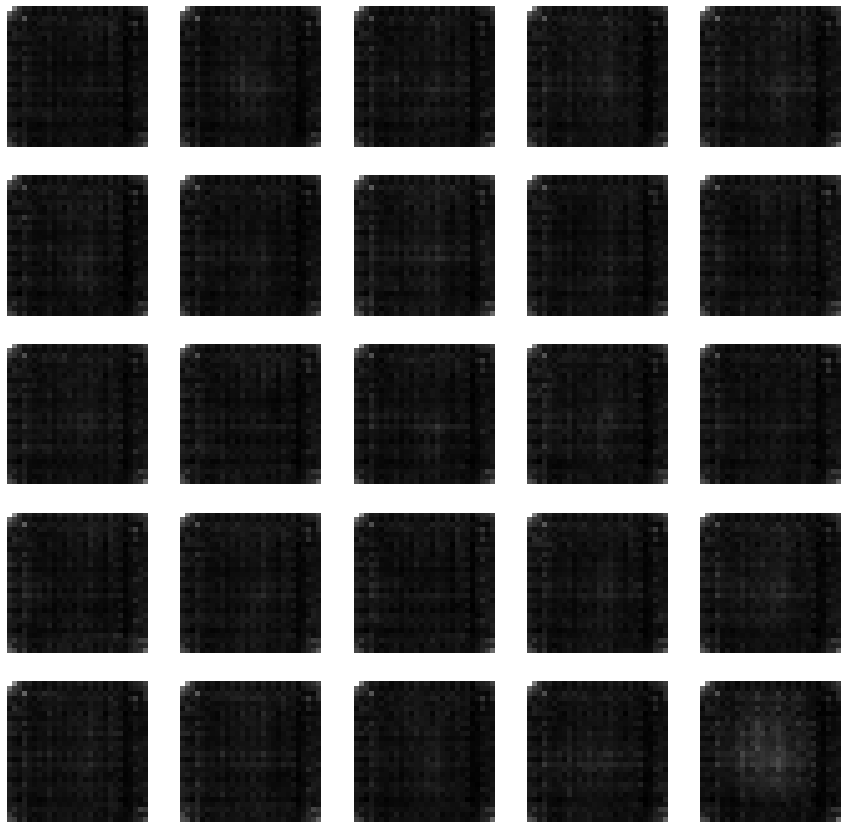

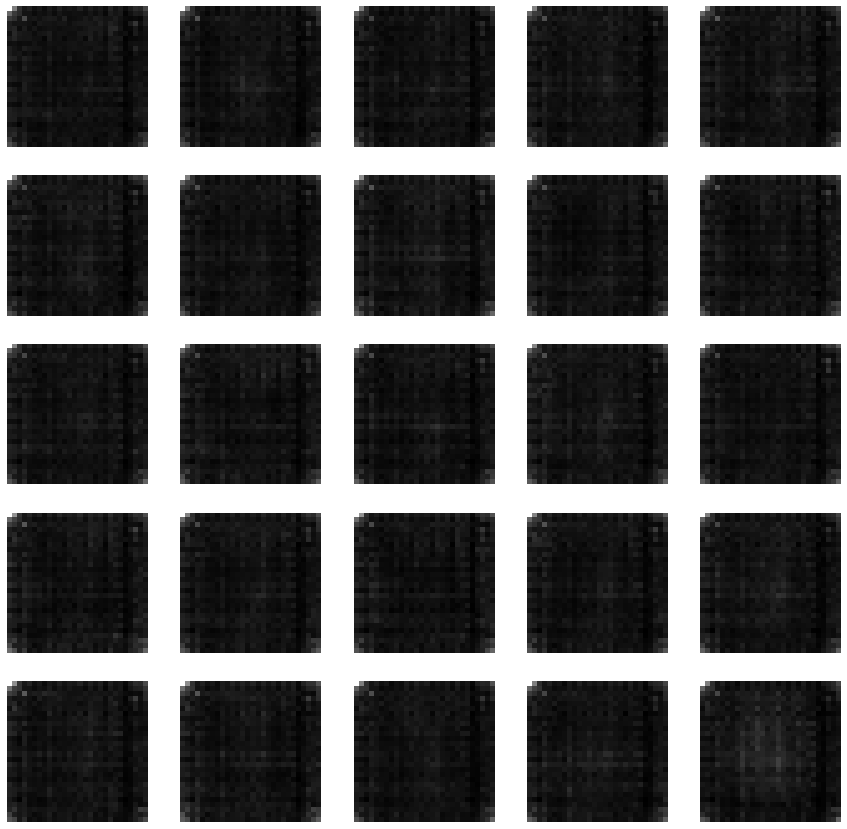

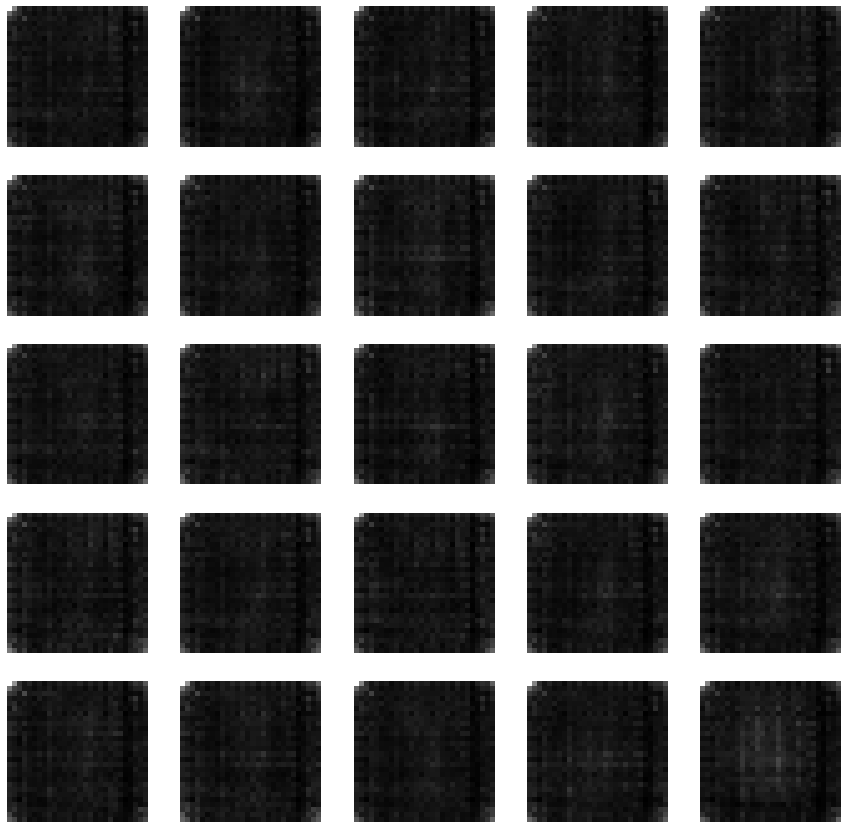

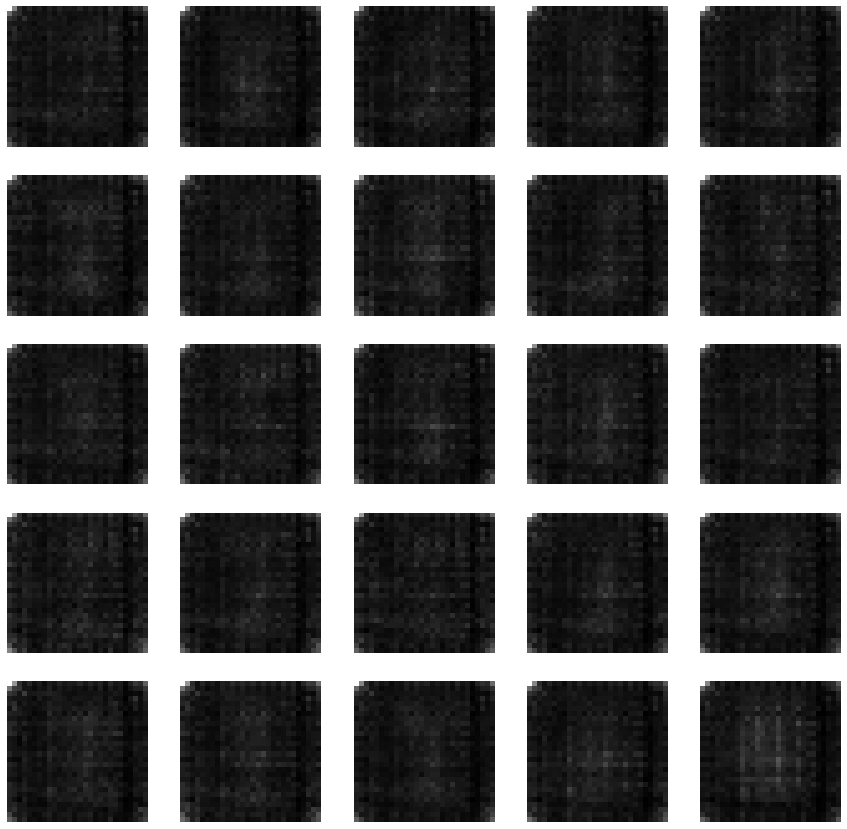

In [75]:
epochs = 50
noise_dim = 100
seed = tf.random.normal([5*5, noise_dim])

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
stat = {}

for epoch in range(epochs):
    stat[epoch] = []
    print(f'\tStart epoch {epoch}')
    start = time.time()
    for image_batch in train_dataset:
        noise = tf.random.normal([BATCH_SIZE, noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            gen_images = generator(noise, training=True)
            
            real_output = discriminator(image_batch, training=True)
            fake_output = discriminator(gen_images, training=True)
            
            real_loss = cross_entropy(tf.ones_like(real_output), real_output)
            fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
            disc_loss = real_loss + fake_loss
            gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        stat[epoch].append([np.average(real_output), np.average(fake_output), real_loss.numpy(), fake_loss.numpy(), gen_loss.numpy()])
    
    print(f'time: {time.time() - start}')
    #display.clear_output(wait=True)
    predictions = generator(seed, training=False)
    fig = plt.figure(figsize=(15,15))
    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig(f'epoch_{epoch}.png')
    #plt.show()


In [ ]:
stat

{0: [[0.6769239, 0.017654272, 0.41416508, 0.70396334, 0.6863091],
  [0.7604065, 0.086421564, 0.3871256, 0.7389629, 0.65254134],
  [0.6751682, 0.04605589, 0.4143664, 0.7185759, 0.67252004],
  [0.6750804, 0.009559767, 0.4144816, 0.699862, 0.69030225]],
 1: [[0.65327847, 0.0026224211, 0.42242742, 0.69621533, 0.6935929],
  [0.68025136, 6.280118e-05, 0.41299832, 0.69520664, 0.6951438],
  [0.67601526, 0.013670899, 0.41411555, 0.7018041, 0.68813324],
  [0.7118065, 0.012934865, 0.40279308, 0.7017963, 0.6888614]],
 2: [[0.69533706, -0.019582184, 0.40773278, 0.685417, 0.7049992],
  [0.6400821, -0.057562042, 0.42621422, 0.6669427, 0.72450477],
  [0.6188927, -0.041986987, 0.43442768, 0.67455494, 0.716542],
  [0.6381738, -0.015319316, 0.42785645, 0.6878693, 0.70318866]],
 3: [[0.66579866, -0.0072776293, 0.41820738, 0.69166315, 0.69894075],
  [0.6403889, 0.0077246916, 0.42720723, 0.6994997, 0.69177496],
  [0.6249958, -0.022773106, 0.4320023, 0.68390167, 0.7066748],
  [0.56991214, -0.036658935, 0.451

In [ ]:
with open('big_stat.txt', 'w') as big, open('stat.txt', 'w') as sw:
    sw.write('N \t disc_av_pred_real     \t disc_av_pred_fake    \t disc_av_real_loss     \t disc_av_fake_loss     \t generator_av_loss \n')
    for i in stat:
        arr = np.array(stat[i])
        sw.write(f'{i} \t {np.average(arr[:,0])} \t {np.average(arr[:,1])} \t {np.average(arr[:,2])} \t {np.average(arr[:,3])} \t {np.average(arr[:,4])} \n')

        big.write(f'\t\t\tEPOCH {i}\n')
        big.write('disc_pred_real     \t disc_pred_fake    \t disc_real_loss     \t disc_fake_loss     \t generator_loss \n')
        for el in arr:
            big.write('\t\t   \t\t'.join(map(str, el)) + '\n')
        big.write('\n\n')